In [1]:
import glob, os, sys
import ROOT
# sys.path.append("..")
# from utils.utils import *
import uproot, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier 
import pickle
import shap

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

Welcome to JupyROOT 6.30/04


/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/ROOT/_facade.py:154: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [2]:
Ztt_inc = [
    700792, 700793, 700794, 700901, 700902, 700903, 700982 
]
ttV = [
    522024, 522028, 522032, 522036, 522040, 700995, 700996, 700997    
]
# Diboson
VV = [
    701040, 701045, 701050, 
    #701055, 
    701060, #701065, 
    701085, 701095, 701105, 701110, 701115, 701125 
]
# Single-Top and ttbar (new samples now!)
Top = [
    601229, 601230, 601237, 601348, 601349, 601350, 601351, #601352, 601355,
]
W = [
    700777, 700778, 700779, # Wenu
    700780, 700781, 700782, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700783, 700784, 700785,
]
# W(tau/mu/e + nu) + jets
Zll_inc = [
   700786, 700787, 700788, 700895, 700896, 700897,
   700789, 700790, 700791, 700898, 700899, 700900,
   700981,
      
]
# Signal samples (new)
ggH = [
    # mc23 DSIDs
    603414, 603415, 603416, 603417,
    603418,
    602632
]
VBFH = [
    # mc20 DSIDs
    603422, 603423, 603424, 603425,
    601599,
]
WH = [603426, 603427]
ZH = [603428]
ttH = [603419,603420,603421]

LUMI = {
    '22': 26071.4,
    '23': 25767.5,
    '24': 109400.0,
}

LUMI_SCALE = {
    '22': 1,
    '23': 1,
    '24': 1,
}

In [6]:
def read_event_weights(event_id, data_year):
    file_path = '../data/xsec_sumofweights_nom_run3.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])
    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        # If DSID doesn't exist or has zero sum weights, set weight to 1
        if (event_weight is None or sum_event_weights is None or 
            sum_event_weights == 0.0):
            results[event_id] = 1.0
            print(f"DSID {event_id} not found for year {data_year} - using weight 1.0")
        else: 
            print(f"DSID {event_id}, year: {data_year}, weight: {event_weight}, sum: {sum_event_weights}")
            results[event_id] = event_weight / sum_event_weights
    return results

In [7]:
# Define datasets and processes
datasets = ['mc23a', 'mc23d', 'mc23e']

categories = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ttH': ttH, 'ZH': ZH
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 
        'W': W, 'Zll_inc': Zll_inc,
        'Top': Top, 'ttV': ttV
    }
}

# Initialize a dictionary to store weights
weights = {}
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            print(f"\nProcessing {process_name} for {dataset}...")
            # Fetch weights for all DSIDs (missing ones get weight 1.0)
            process_weights = fetch_weights(process_list, dataset)
            weights[dataset][category][key] = process_weights
            print(f"✓ Stored weights for {process_name} ({len(process_weights)} DSIDs)")

weights


Processing VBFH for mc23a...
DSID 603422, year: mc23a, weight: 0.05048950954, sum: 50058121.76775932
DSID 603423, year: mc23a, weight: 0.01739184846, sum: 24560735.503458977
DSID 603424, year: mc23a, weight: 0.020462623080000002, sum: 24985585.3717494
DSID 603425, year: mc23a, weight: 0.01476969442, sum: 49760343.502305984
DSID 601599, year: mc23a, weight: 0.0471568398113343, sum: 5925337.189682007
✓ Stored weights for VBFH (5 DSIDs)

Processing ggH for mc23a...
DSID 603414, year: mc23a, weight: 0.61191944, sum: 200001123.0151981
DSID 603415, year: mc23a, weight: 0.24496432399999998, sum: 72692784.98140621
DSID 603416, year: mc23a, weight: 0.24483329199999998, sum: 72140742.51296893
DSID 603417, year: mc23a, weight: 0.174076012, sum: 183133495.64637947
DSID 603418, year: mc23a, weight: 0.0085, sum: 18553.604413885623
DSID 602632, year: mc23a, weight: 0.5841733480349975, sum: 101322490.36887306
✓ Stored weights for ggH (6 DSIDs)

Processing WH for mc23a...
DSID 603426, year: mc23a, wei

{'mc23a': {'signal': {'VBFH_ws_a': {603422: 1.0086177378816182e-09,
    603423: 7.081159461837226e-10,
    603424: 8.189771332368541e-10,
    603425: 2.968165687866593e-10,
    601599: 7.958507389832619e-09},
   'ggH_ws_a': {603414: 3.059580020225687e-09,
    603415: 3.3698574633322744e-09,
    603416: 3.393828278881184e-09,
    603417: 9.505416329524503e-10,
    603418: 4.581320055330355e-07,
    602632: 5.765485490025613e-09},
   'WH_ws_a': {603426: 3.1657048433424415e-08, 603427: 3.202291698195834e-08},
   'ttH_ws_a': {603419: 1.5896349370988567e-08,
    603420: 3.521125102032827e-08,
    603421: 2.524521590914141e-08},
   'ZH_ws_a': {603428: 1.5369550121230807e-08}},
  'background': {'Ztt_inc_ws_a': {700792: 1.1763215375284592e-12,
    700793: 1.5682611793990831e-12,
    700794: 1.0048256455748767e-12,
    700901: 5.903717928389563e-12,
    700902: 5.0844988748538865e-12,
    700903: 5.568047747372977e-12,
    700982: 7.314617485293077e-11},
   'VV_ws_a': {701040: 6.836163854566494

In [8]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',
'NOMINAL_pileup_random_run_number',
'ditau_obj_bdt_score',
'ditau_obj_omni_score',
'ditau_obj_leadsubjet_charge',
'ditau_obj_leadsubjet_n_core_tracks',
'ditau_obj_leadsubjet_p4',
'ditau_obj_nSubjets',
'ditau_obj_n_tracks',
'ditau_obj_p4',
'ditau_obj_subleadsubjet_charge',
'ditau_obj_subleadsubjet_n_core_tracks',
'ditau_obj_subleadsubjet_p4',
'jets_p4',
'event_number',
'met_p4',
'met_sumet',
'met_hpto_p4',
'event_is_bad_batman',
'NOMINAL_pileup_combined_weight',
'n_bjets_GN2v01_FixedCutBEff_70',
'weight_mc']
# Signal-specific branches (includes theory weights)
signal_branches = branches + ['theory_weights_nominal']
# Background-specific branches (only has weight_mc)
background_branches = branches

data_branches = \
[
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_omni_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'jets_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_GN2v01_FixedCutBEff_70']

In [9]:
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/mc/ditau_hh/{year}/nom/user.*.{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18', is_signal=False):
    out = []
    hlt_branches = {
        '22': ['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100', 'HLT_xe65_cell_xe90_pfopufit_L1XE50', 'HLT_tau160_mediumRNN_tracktwoMVA_L1TAU100'],
        '23': ['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100', 'HLT_xe65_cell_xe90_pfopufit_L1XE50', 'HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'],
        '24': ['HLT_j400_pf_ftf_preselj225_L1jJ180', 'HLT_j460_a10t_lcw_jes_L1jLJ140', 'HLT_xe65_cell_xe90_pfopufit_L1jXE100', 'HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140']
    }
    if is_signal:
        branches_to_read = signal_branches
    else:
        branches_to_read = background_branches
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches_to_read + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')
                # Apply different weights for signal vs background
                if is_signal:
                    mc_weight = events['theory_weights_nominal']
                else:
                    mc_weight = events['weight_mc']  
                events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                    mc_weight * events['NOMINAL_pileup_combined_weight'] * \
                                    LUMI_SCALE[year] * LUMI[year]
                out = ak.concatenate((out, events))
    return out


In [10]:
# Year mapping
year_map = {
    'mc23a': '22',
    'mc23d': '23', 
    'mc23e': '24'
}
# Process mapping
processes = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ttH': ttH, 'ZH': ZH
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 
        'W': W, 'Zll_inc': Zll_inc,
        'Top': Top, 'ttV': ttV
    }
}

total_mc = {}
for dataset in ['mc23a', 'mc23d', 'mc23e']:
    suffix = dataset[-1]
    year = year_map[dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            # Determine if this is a signal process
            is_signal = category == 'signal'
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year, is_signal=is_signal)
            print(f"✓ Processed {proc_name} with {len(proc_list)} DSIDs")
    total_mc[dataset] = dataset_results

✓ Processed VBFH with 5 DSIDs
✓ Processed ggH with 6 DSIDs
✓ Processed WH with 2 DSIDs
✓ Processed ttH with 3 DSIDs
✓ Processed ZH with 1 DSIDs
✓ Processed Ztt_inc with 7 DSIDs
✓ Processed VV with 10 DSIDs
✓ Processed W with 9 DSIDs
✓ Processed Zll_inc with 13 DSIDs
✓ Processed Top with 7 DSIDs
✓ Processed ttV with 8 DSIDs
✓ Processed VBFH with 5 DSIDs
✓ Processed ggH with 6 DSIDs
✓ Processed WH with 2 DSIDs
✓ Processed ttH with 3 DSIDs
✓ Processed ZH with 1 DSIDs
✓ Processed Ztt_inc with 7 DSIDs
✓ Processed VV with 10 DSIDs
✓ Processed W with 9 DSIDs
✓ Processed Zll_inc with 13 DSIDs
✓ Processed Top with 7 DSIDs
✓ Processed ttV with 8 DSIDs
✓ Processed VBFH with 5 DSIDs
✓ Processed ggH with 6 DSIDs
✓ Processed WH with 2 DSIDs
✓ Processed ttH with 3 DSIDs
✓ Processed ZH with 1 DSIDs
✓ Processed Ztt_inc with 7 DSIDs
✓ Processed VV with 10 DSIDs
✓ Processed W with 9 DSIDs
✓ Processed Zll_inc with 13 DSIDs
✓ Processed Top with 7 DSIDs
✓ Processed ttV with 8 DSIDs


In [11]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data{year}/user.*/user.*.root'

def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '22':
            branches_read.extend(['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100', 'HLT_xe65_cell_xe90_pfopufit_L1XE50', 'HLT_tau160_mediumRNN_tracktwoMVA_L1TAU100'])
        elif year == '23':
            branches_read.extend(['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100', 'HLT_xe65_cell_xe90_pfopufit_L1XE50', 'HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
        elif year == '24':
            branches_read.extend(['HLT_j400_pf_ftf_preselj225_L1jJ180', 'HLT_j460_a10t_lcw_jes_L1jLJ140', 'HLT_xe65_cell_xe90_pfopufit_L1jXE100', 'HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_22 = read_data_root(year='22')
data_23 = read_data_root(year='23')
data_24 = read_data_root(year='24')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data22/user.ademaria.Htt_02.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v02_p6700.n_20_HS/user.ademaria.45745390._000015.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data22/user.ademaria.Htt_02.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v02_p6700.n_20_HS/user.ademaria.45745390._000083.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data22/user.ademaria.Htt_02.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v02_p6700.n_20_HS/user.ademaria.45745390._000224.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data22/user.ademaria.Htt_02.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v02_p6700.n_20_HS/user.ademaria.45745390._000144.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V02/data/ditau_hh/data22/user.ademari

In [12]:
def save_raw_data(data, data_type='MC'):
    """Process and save raw data before any cuts"""
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    output_file = f'/global/homes/a/agarabag/pscratch/ditdau_samples/raw_{data_type.lower()}_run3.pkl'
    
    # Save data directly
    with open(output_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved raw {data_type} data to {output_file}")
    
    return data

save_raw_data(total_mc, 'MC')
save_raw_data({'data_22': data_22,'data_23': data_23, 'data_24': data_24}, 'data')

Saved raw MC data to /global/homes/a/agarabag/pscratch/ditdau_samples/raw_mc_run3.pkl
Saved raw data data to /global/homes/a/agarabag/pscratch/ditdau_samples/raw_data_run3.pkl


{'data_22': <Array [{event_number: 807136162, ...}, ...] type='409189 * {event_number: ...'>,
 'data_23': <Array [{event_number: 1909624435, ...}, ...] type='443962 * {event_number:...'>,
 'data_24': <Array [{event_number: 3505957443, ...}, ...] type='2712184 * {event_number...'>}

In [2]:
ditau_id_cut = 0.9993

def data_Cut(t, year):
    if year == '22':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100']) | (t['HLT_xe65_cell_xe90_pfopufit_L1XE50']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1TAU100'])
    elif year == '23':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100']) | (t['HLT_xe65_cell_xe90_pfopufit_L1XE50']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
    elif year == '24':
        hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180']) | (t['HLT_xe65_cell_xe90_pfopufit_L1jXE100']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
        # hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180']) | (t['HLT_j460_a10t_lcw_jes_L1jLJ140']) | (t['HLT_xe65_cell_xe90_pfopufit_L1jXE100']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
    else:
        raise ValueError(f"Unsupported year: {year}") 
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] < ditau_id_cut) & \
               (t['n_bjets_GN2v01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]

def mc_Cut(t, year):
    if year == '22':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100']) | (t['HLT_xe65_cell_xe90_pfopufit_L1XE50']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1TAU100'])
    elif year == '23':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100']) | (t['HLT_xe65_cell_xe90_pfopufit_L1XE50']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
    elif year == '24':
        hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180']) | (t['HLT_xe65_cell_xe90_pfopufit_L1jXE100']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
        # hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180']) | (t['HLT_j460_a10t_lcw_jes_L1jLJ140']) | (t['HLT_xe65_cell_xe90_pfopufit_L1jXE100']) | (t['HLT_tau160_mediumRNN_tracktwoMVA_L1eTAU140'])
    else:
        raise ValueError(f"Unsupported year: {year}") 
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_GN2v01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] >= ditau_id_cut) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]


In [3]:
def apply_cuts(data, data_type='MC'):
    """
    Apply cuts to both MC and real data
    data_type: 'MC' or 'data'
    """
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    cut_results = {}
    
    if data_type == 'MC':
        year_map = {
            'mc23a': '22',
            'mc23d': '23',
            'mc23e': '24',
        }
        # Handle MC data structure (nested dictionary)
        for dataset, results in data.items():
            year = year_map[dataset]
            cut_results[dataset] = {}
            
            print(f"Applying MC cuts to {dataset} (year {year})...")
            for var_name, sample in results.items():
                try:
                    cut_results[dataset][var_name] = mc_Cut(sample, year)
                    print(f"Processed {var_name}")
                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    cut_results[dataset][var_name] = None
    
    else:
        # Handle real data (direct samples)
        data_vars = {
            'data_22': ('22', data['data_22']),
            'data_23': ('23', data['data_23']),
            'data_24': ('24', data['data_24']),
        }
        
        for name, (year, sample) in data_vars.items():
            print(name, year, sample)
            try:
                cut_results[name] = data_Cut(sample, year)
                print(f"Processed {name}")
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                cut_results[name] = None

    return cut_results


In [4]:
with open('/global/homes/a/agarabag/pscratch/ditdau_samples/raw_mc_run3.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)

with open('/global/homes/a/agarabag/pscratch/ditdau_samples/raw_data_run3.pkl', 'rb') as f:
    uncut_data = pickle.load(f)


In [ ]:
# cut_data = apply_cuts({'data_18': data_18, 'data_17': data_17, 
#                        'data_16': data_16, 'data_15': data_15}, data_type='data')
# # cut_data = apply_cuts({'data_17': data_17}, data_type='data')
# cut_mc = apply_cuts(total_mc, data_type='MC')

In [11]:
cut_data = apply_cuts({'data_22': uncut_data['data_22'], 'data_23': uncut_data['data_23'], 'data_24': uncut_data['data_24']}, data_type='data')
cut_mc = apply_cuts(uncut_mc, data_type='MC')

data_22 22 [{event_number: 807136162, met_p4: {fP: {...}, ...}, met_sumet: 578, ...}, ...]
Processed data_22
data_23 23 [{event_number: 1909624435, met_p4: {fP: {...}, ...}, met_sumet: 766, ...}, ...]
Processed data_23
data_24 24 [{event_number: 3505957443, met_p4: {fP: {...}, ...}, met_sumet: ..., ...}, ...]
Processed data_24
Applying MC cuts to mc23a (year 22)...
Processed VBFH_a
Processed ggH_a
Processed WH_a
Processed ttH_a
Processed ZH_a
Processed Ztt_inc_a
Processed VV_a
Processed W_a
Processed Zll_inc_a
Processed Top_a
Processed ttV_a
Applying MC cuts to mc23d (year 23)...
Processed VBFH_d
Processed ggH_d
Processed WH_d
Processed ttH_d
Processed ZH_d
Processed Ztt_inc_d
Processed VV_d
Processed W_d
Processed Zll_inc_d
Processed Top_d
Processed ttV_d
Applying MC cuts to mc23e (year 24)...
Processed VBFH_e
Processed ggH_e
Processed WH_e
Processed ttH_e
Processed ZH_e
Processed Ztt_inc_e
Processed VV_e
Processed W_e
Processed Zll_inc_e
Processed Top_e
Processed ttV_e


In [12]:
def combine_mc_years(cut_mc):    
    combined = {}
    # Get base process names (without year suffix)
    base_processes = set()
    for dataset in cut_mc.values():
        for proc in dataset.keys():
            base_name = proc.rsplit('_', 1)[0]  # Remove _e, _d, _a suffix
            base_processes.add(base_name)
    
    # Combine each process across years
    for base_proc in base_processes:
        year_data = []
        for dataset in ['mc23a', 'mc23d', 'mc23e']:
            proc_name = f"{base_proc}_{dataset[-1]}"
            if proc_name in cut_mc[dataset]:
                year_data.append(cut_mc[dataset][proc_name])        
        if year_data:
            combined[base_proc] = ak.concatenate(year_data)
            print(f"Combined {base_proc} across years")
    
    return combined

def combine_data_years(cut_data):    
    # Extract arrays from all years
    data_arrays = [
        cut_data['data_22'],
        cut_data['data_23'],
        cut_data['data_24']
    ]
    
    # Combine using awkward array concatenation
    combined_data = ak.concatenate(data_arrays)
    print(f"Combined data from all years: {len(combined_data)} events")
    
    return combined_data

In [13]:
combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

Combined VBFH across years
Combined ttH across years
Combined ZH across years
Combined VV across years
Combined WH across years
Combined W across years
Combined ggH across years
Combined ttV across years
Combined Zll_inc across years
Combined Ztt_inc across years
Combined Top across years
Combined data from all years: 448215 events


In [14]:
#combine all mc the samples
vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

#combine all data samples
data_cut = combines_data
print("#fakes:", len(data_cut))
print(len(ztt_inc_cut))

#fakes: 448215
834130


In [15]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [16]:
ff_scale = 1

def determine_prong(subleadNTracks):
    if subleadNTracks == 1:
        return 1
    elif subleadNTracks == 3:
        return 2
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_13p1p": file["FF_13p1p_ditau_obj_subleadsubjet_pt_ff"].to_hist(),
        "h_ff_13p3p": file["FF_13p3p_ditau_obj_subleadsubjet_pt_ff"].to_hist(),
    }
    return histograms

def fake_factor_calc(subleadNTracks, sublead_pt, histograms):
    weights = []
    
    for sublead, pt in zip(subleadNTracks, sublead_pt):
        prongness = determine_prong(sublead)
        
        if prongness == 1:
            hist = histograms["h_ff_13p1p"]
        elif prongness == 2:
            hist = histograms["h_ff_13p3p"]
        else:
            weights.append(-1)
            continue
        
        # Use numpy's digitize for clean, efficient binning with clamping
        bin_edges = hist.axes[0].edges
        bin_idx = np.digitize(pt, bin_edges) - 1  # digitize returns 1-based, convert to 0-based
        
        # Clamp to valid range
        bin_idx = np.clip(bin_idx, 0, len(hist.values()) - 1)        
        weight = hist.values()[bin_idx]
        weights.append(weight)
    
    return [w * ff_scale for w in weights]

In [17]:
def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [18]:
def Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.zip(
        {
        'px': t['met_p4'].fP.fX, 
        'py': t['met_p4'].fP.fY,
        'pz': t['met_p4'].fP.fZ,
        'energy': t['met_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(leadsubjet_p4 + subleadsubjet_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + (leadsubjet_p4 + subleadsubjet_p4)).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
            met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
            t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

def Data_Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    event_id = t['event_number']
    
    ######
    histograms = load_histograms("../data/FF_hadhad_ratio_1d_run3.root")

    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    delta_r = np.array(delta_R)
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms) ###3d
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms) ###2d
    fake_factor = fake_factor_calc(subleadNTracks, sublead_pt, histograms) ###1d


    ######
    ######
    met_2d = vector.zip(
        {
        'px': t['met_p4'].fP.fX, 
        'py': t['met_p4'].fP.fY,
        'pz': t['met_p4'].fP.fZ,
        'energy': t['met_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(leadsubjet_p4 + subleadsubjet_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + (leadsubjet_p4 + subleadsubjet_p4)).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
            t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

In [19]:
def cut_x1_x2(t):
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2) & (np.array(t[7]) < 2) & 
                        (np.array(t[1]) > 50) & (np.array(t[2]) > 15) & (np.array(t[4]) > 60) & (np.array(t[16]) > 0))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [20]:
calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 
             'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead',
             'met_centrality', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks', 'e_ratio_lead', 'e_ratio_sublead',
             'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau']


In [21]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)
vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)
vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)

In [22]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_plot = pd.DataFrame(np.array(data_plot).T, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,...,subleadsubjet_charge,leadsubjet_n_core_tracks,subleadsubjet_n_core_tracks,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta,delta_phi_met_ditau
0,381.641906,282.938219,57.901250,77.669032,70.964950,83.598518,1.641737,0.515718,0.163532,0.806463,...,-1.0,3.0,3.0,0.700664,0.146160,273.811686,-0.012206,-0.187687,-0.060659,-2.624988
1,464.691812,407.078719,37.270785,46.777657,61.365633,67.363675,0.945134,0.494385,0.127178,1.860646,...,1.0,3.0,3.0,0.879415,0.063598,504.416238,1.814861,1.561203,1.808660,-0.122545
2,496.442125,426.807375,22.211939,79.246106,64.868671,100.304801,1.255747,0.473696,0.119723,0.030141,...,1.0,3.0,3.0,0.809368,0.078818,383.557971,1.593145,2.249184,1.650926,2.974818
3,420.707031,321.544031,60.132918,114.378933,74.599363,148.391981,0.859907,0.682323,0.152385,2.040400,...,1.0,1.0,1.0,0.728318,0.129833,439.729717,-1.051308,-0.988574,-1.085739,-0.154889
4,585.152438,513.847437,29.135021,78.241245,146.819245,167.577511,0.904265,0.227254,0.245099,2.473762,...,1.0,3.0,1.0,0.860689,0.047944,676.791927,-1.628479,-1.609161,-1.647755,-0.370621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25192,452.911656,340.403531,18.649391,65.064836,75.096790,61.459996,0.811226,1.478797,0.144317,-1.879345,...,-1.0,3.0,1.0,0.714618,0.039747,428.563749,-0.193107,-0.254872,-0.187392,-0.094844
25193,429.783437,330.788375,58.070004,73.322314,62.621006,65.852919,1.234037,0.997919,0.119260,0.832513,...,-1.0,3.0,1.0,0.780719,0.098245,323.251426,-1.707733,-1.340482,-1.685618,-3.088586
25194,353.783281,253.042141,32.904688,37.505824,77.326862,71.189160,1.745416,0.164893,0.139398,-1.373815,...,-1.0,1.0,1.0,0.647239,0.078692,338.534543,1.159115,1.073547,1.258050,0.878056
25195,337.977281,118.620352,65.848141,25.732286,85.425162,37.790739,0.687195,0.673280,0.188367,1.754793,...,-1.0,1.0,1.0,0.370922,0.200999,268.788488,0.866212,0.831088,0.655873,-0.003398


In [19]:

# import matplotlib.gridspec as gridspec


# # Create figure and gridspec
# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.1)

# # Calculate histograms
# bins = np.linspace(0, 1, 30)  # Fixed range 0-3
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # Get histogram values
# hist_ff, _ = np.histogram(ff_995, bins=bins, density=True)
# hist_data, _ = np.histogram(data_plot['fake_factor'], bins=bins, density=True)

# # Top plot - Histograms
# ax1 = plt.subplot(gs[0])
# ax1.hist(ff_995, bins=bins, alpha=0.5, label='FF_995', density=True)
# ax1.hist(data_plot['fake_factor'], bins=bins, alpha=0.5, label='FF_99', density=True)
# ax1.legend()
# ax1.set_xlabel('')
# ax1.set_ylabel('Normalized Entries')
# # ax1.set_xlim(0, 3)

# # Bottom plot - Ratio using bin centers
# ax2 = plt.subplot(gs[1])
# ratio = np.divide(hist_ff, hist_data, where=hist_data!=0)  # Avoid division by zero
# ax2.scatter(bin_centers, ratio, alpha=0.5)
# ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# ax2.set_xlabel('Fake Factor')
# ax2.set_ylabel('FF_995/Data')
# # ax2.set_xlim(0, 3)
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [35]:
# print(data_plot[data_plot['fake_factor'] == -999])
print(data_plot[data_plot['fake_factor'] < 0])

Empty DataFrame
Columns: [ditau_pt, leadsubjet_pt, subleadsubjet_pt, visible_ditau_m, met, collinear_mass, x1, x2, met_sig, met_phi, event_number, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead, met_centrality, omni_score, leadsubjet_charge, subleadsubjet_charge, leadsubjet_n_core_tracks, subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead, higgs_pt, leadsubjet_eta, subleadsubjet_eta, ditau_eta, delta_phi_met_ditau]
Index: []

[0 rows x 37 columns]


In [23]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0
data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

#print how many events of each sample
print('VBFH:', len(vbfh_plot))
print('GGH:', len(ggh_plot))
print('WH:', len(wh_plot))
print('ZH:', len(zh_plot))
print('TTH:', len(tth_plot))
print('VV:', len(vv_plot))
print('TOP:', len(top_plot))
print('ZTT:', len(ztt_plot))
print('TTV:', len(ttv_plot))
print('W:', len(w_plot))
print('ZLL:', len(zll_plot))
print('Data:', len(data_plot))

df = pd.concat([
    vbfh_plot, ggh_plot, wh_plot, zh_plot, tth_plot,
    vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot, data_plot
])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'met_centrality',
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 
    'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks',
    'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead',
    'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau'
]

df = df[training_var]

VBFH: 48527
GGH: 9814
WH: 6368
ZH: 5503
TTH: 1852
VV: 100043
TOP: 111
ZTT: 373805
TTV: 649
W: 183
ZLL: 24272
Data: 25197


In [20]:
# # Define variables and their plotting ranges
# plot_configs = {
#     'leadsubjet_pt': (50, 650, 50),      # GeV
#     'subleadsubjet_pt': (0, 300, 50),   # GeV
#     'visible_ditau_m': (0, 150, 50),    # GeV
#     'collinear_mass': (25, 200, 50),     # GeV
#     'delta_R': (0.2, 1, 50),              # Angular separation
#     # 'delta_R_lead': (0.2, 0.9, 50),              # Angular separation
#     # 'delta_R_sublead': (0.2, 0.9, 50),              # Angular separation
#     'met': (0, 550, 50),                # GeV
#     'met_sig': (0, 1, 50),             # MET significance
#     'met_centrality': (-1.5, 1.5, 50),       # Centrality
#     'x1': (0, 2, 50),                   # Momentum fraction
#     'x2': (0, 2, 50),                   # Momentum fraction
#     'delta_phi_met_ditau': (-3.2, 3.2, 50),  
#     # 'combined_weights': (-.005, .005, 50),  # Combined weights
#     # 'delta_phi_met_ditau_normalized': (-1, 1, 50),     
#     # 'leadsubjet_n_core_tracks': (0, 20, 50),       
#     # 'subleadsubjet_n_core_tracks': (0, 20, 50),      
#     # 'e_ratio_sublead': (0, 1, 50),       # Energy ratio
#     # 'e_ratio_lead': (0, 1, 50),       # Energy ratio
#     # 'kappa': (0, 1, 50),           # GeV
#     # 'k_t': (0, 100, 50),             # GeV
# }

# # Signal and background processes
# signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
# background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, top_plot, ttv_plot, data_plot]

# # background_processes = [zll_plot]
# # Create plot for each variable
# for var, (xmin, xmax, nbins) in plot_configs.items():
#     plt.figure(figsize=(8, 6))
#     plt_bins = np.linspace(xmin, xmax, nbins)
    
#     if var == 'delta_phi_met_ditau_normalized':
#         # Process signal with the transformation
#         combined_signal = np.concatenate([(process['delta_phi_met_ditau'] + np.pi) / 2*np.pi 
#                                          for process in signal_processes])
#         # Process background with the transformation
#         combined_background = np.concatenate([(process['delta_phi_met_ditau'] + np.pi) / 2*np.pi 
#                                              for process in background_processes])
#     else:
#         # Regular plotting for other variables
#         combined_signal = np.concatenate([process[var] for process in signal_processes])
#         combined_background = np.concatenate([process[var] for process in background_processes])
    
#     # Plot signal
#     plt.hist(combined_signal, bins=plt_bins, histtype='stepfilled', 
#              alpha=0.3, label='Combined Signal', color='red', density=True)
    
#     # Plot background
#     plt.hist(combined_background, bins=plt_bins, histtype='stepfilled', 
#              alpha=0.3, label='Combined Background', color='blue', density=True)
    
#     #print area under curve
#     print('Signal:', np.sum(combined_signal) / (len(combined_signal) * (xmax - xmin) / nbins))
     
#     plt.legend(fontsize=14)
#     plt.grid(True)
    
#     if var == 'delta_phi_met_ditau_normalized':
#         plt.xlabel('(Δφ(MET, DiTau) + π) / π', fontsize=22)
#     else:
#         plt.xlabel(var, fontsize=22)
        
#     plt.ylabel('Events', fontsize=22)
#     plt.show()

#     #print min and max of each variable
#     print(var, 'bkg min:', np.min(combined_background), 'bkg max:', np.max(combined_background))
#     print(var, 'sig min:', np.min(combined_signal), 'sig max:', np.max(combined_signal))

In [29]:
# Set ATLAS style
ROOT.gROOT.SetStyle("ATLAS")

# Define variables and their plotting ranges with proper labels
plot_configs = {
    'leadsubjet_pt': (50, 650, 50, 'Leading subjet p_{T} [GeV]'),
    'subleadsubjet_pt': (0, 300, 50, 'Subleading subjet p_{T} [GeV]'),
    'visible_ditau_m': (0, 150, 50, 'M_{vis} [GeV]'),
    'collinear_mass': (25, 200, 50, 'M_{collinear} [GeV]'),
    'delta_R': (0.2, 1, 50, '#Delta R_{lead,subl}'),
    'met': (0, 550, 50, 'E_{T}^{miss} [GeV]'),
    'met_sig': (0, 1, 50, 'E_{T}^{miss} significance'),
    'met_centrality': (-1.5, 1.5, 50, 'E_{T}^{miss} centrality'),
    'x1': (0, 2, 50, 'E_{vis}^{lead}/E_{sum}^{lead}'),
    'x2': (0, 2, 50, 'E_{vis}^{subl}/E_{sum}^{subl}'),
    'delta_phi_met_ditau': (-3.2, 3.2, 50, '#Delta #phi(E_{T}^{miss}, lead+subl)'),
}

# Signal and background processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, top_plot, ttv_plot, data_plot]

# Create plot for each variable
for var, (xmin, xmax, nbins, xlabel) in plot_configs.items():
    
    # Combine data
    combined_signal = np.concatenate([process[var] for process in signal_processes])
    combined_background = np.concatenate([process[var] for process in background_processes])
    
    # Create histograms
    hist_signal = ROOT.TH1F(f"hist_signal_{var}", f"Signal {var}", nbins, xmin, xmax)
    hist_background = ROOT.TH1F(f"hist_background_{var}", f"Background {var}", nbins, xmin, xmax)
    
    # Fill histograms
    for value in combined_signal:
        hist_signal.Fill(value)
    
    for value in combined_background:
        hist_background.Fill(value)
    
    # Normalize histograms
    if hist_signal.Integral() > 0:
        hist_signal.Scale(1.0 / hist_signal.Integral())
    if hist_background.Integral() > 0:
        hist_background.Scale(1.0 / hist_background.Integral())
    
    # Create canvas
    canvas = ROOT.TCanvas(f"canvas_{var}", f"Canvas {var}", 800, 800)
    
    # Set styles for signal histogram
    hist_signal.SetLineColor(ROOT.kRed)
    hist_signal.SetFillColorAlpha(ROOT.kRed, 0.3)
    hist_signal.SetLineWidth(2)
    
    # Set styles for background histogram
    hist_background.SetLineColor(ROOT.kAzure+1)
    hist_background.SetFillColorAlpha(ROOT.kAzure+1, 0.3)
    hist_background.SetLineWidth(2)
    
    # Set y-axis range
    max_val = max(hist_signal.GetMaximum(), hist_background.GetMaximum())
    hist_background.SetMaximum(max_val * 1.3)
    
    # Draw histograms
    hist_background.Draw("hist")
    hist_signal.Draw("hist same")
    
    # Set axis titles
    bin_width = (xmax - xmin) / nbins
    hist_background.GetXaxis().SetTitle(xlabel)
    hist_background.GetYaxis().SetTitle(f'Normalized Events / {bin_width:.2f}')
    
    # Set axis title sizes
    hist_background.GetXaxis().SetTitleSize(0.05)
    hist_background.GetYaxis().SetTitleSize(0.05)
    hist_background.GetXaxis().SetLabelSize(0.04)
    hist_background.GetYaxis().SetLabelSize(0.04)
    
    # Create and draw legend
    legend = ROOT.TLegend(0.65, 0.75, 0.88, 0.88)
    legend.SetBorderSize(0)
    legend.SetFillColor(0)
    legend.SetFillStyle(0)
    legend.AddEntry(hist_signal, "Signal", "f")
    legend.AddEntry(hist_background, "Background", "f")
    legend.Draw()
    
    # Add ATLAS text labels
    tex = ROOT.TLatex()
    tex.SetNDC()
    tex.SetTextSize(0.04)
    tex.DrawLatex(0.2, 0.88, "#bf{#it{ATLAS}} Internal")
    tex.SetTextSize(0.03)
    # tex.DrawLatex(0.18, 0.82, "L = 13 TeV")
    # Optional: Add luminosity
    tex.DrawLatex(0.2, 0.82, "L = 162 fb^{-1}")
    
    # Update canvas
    canvas.Update()
    
    # Save canvas
    canvas.SaveAs(f"mva_plots/{var}_comparison.pdf")
    

Info in <TCanvas::Print>: pdf file mva_plots/leadsubjet_pt_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/subleadsubjet_pt_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/visible_ditau_m_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/collinear_mass_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/delta_R_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/met_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/met_sig_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/met_centrality_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/x1_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/x2_comparison.pdf has been created
Info in <TCanvas::Print>: pdf file mva_plots/delta_phi_met_ditau_comparison.pdf has been created


In [32]:
# # Setup parameters
# plt.figure(figsize=(10, 8))
# plot_int = 'omni_score'
# plt_bins = np.linspace(0., 1, 20)

# # Signal processes
# signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
# combined_signal = np.concatenate([process[plot_int] for process in signal_processes])
# print("signal", len(combined_signal))
# print("signal", len(combined_signal[combined_signal < 0.7]))

# # Plot signal
# plt.hist(combined_signal, bins=plt_bins, histtype='step', 
#          label='Combined Signal', color='red', density=True)

# # Background samples with labels and colors
# backgrounds = {
#     # 'VV': (vv_plot, 'blue'),
#     'Z→ττ': (ztt_plot, 'green'),
#     # 'Z→ll': (zll_plot, 'orange'),
#     # 'W': (w_plot, 'purple'),
#     # 'ttV': (ttv_plot, 'brown'),
#     # 'Top': (top_plot, 'cyan'),
#     "data": (data_plot, 'black')
# }

# # Plot each background
# for name, (bkg_process, color) in backgrounds.items():
#     plt.hist(bkg_process[plot_int], bins=plt_bins, histtype='step',
#              label=name, color=color, density=True)

# plt.legend(fontsize=18, ncol=2)
# plt.grid(True)
# plt.yscale('log')
# plt.xlabel(plot_int, fontsize=22)
# plt.ylabel('Events', fontsize=22)
# plt.show()

In [24]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    524260
1     72064
Name: count, dtype: int64

In [25]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

#filter out events with negative weights
# df = df[(df['combined_weights'] > 0) & (df['fake_factor'] > 0)]
# print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
# print(df.loc[df['fake_factor'] < 0, 'fake_factor'])
# print(df['label'].value_counts())

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [26]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [27]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 199178 198469 198677 0 0
Signal Split: 23993 24023 24048 0 0
Background Split: 175185 174446 174629 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


len X_train: 397146
len X_test: 199178
signal scaling factor:  7.261654635851137
len X_train: 397855
len X_test: 198469
signal scaling factor:  7.28157199059137
len X_train: 397647
len X_test: 198677
signal scaling factor:  7.281551982672442


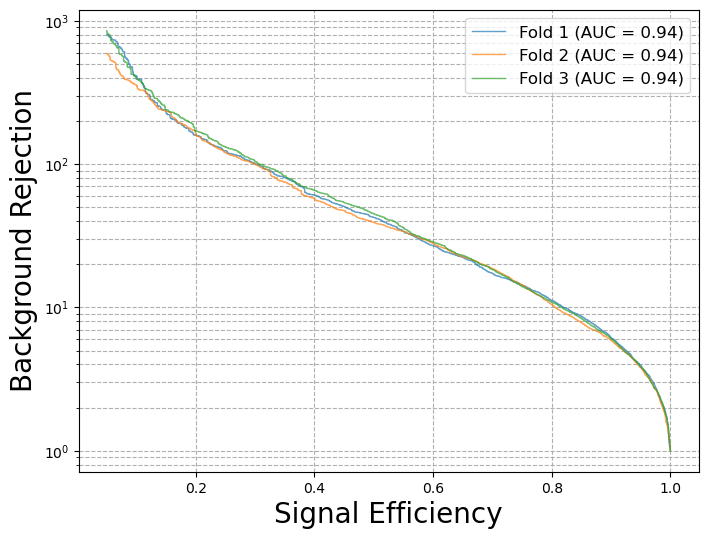

In [29]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

all_shap_values = []
all_feature_names = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_phi_met_ditau': 'f10',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test

    # training_weight = ff_train
    # val_weights = ff_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    # Reverse the feature_name_mapping
    reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
    X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
    all_feature_names.append(X_test_renamed.columns)
    # all_feature_names.append(X_test.columns)

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



In [30]:
print(X_train.columns.tolist(), X_train.dtypes, y_train.dtype, training_weight.dtype)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'] f0     float64
f1     float64
f2     float64
f3     float64
f4     float64
f5     float64
f6     float64
f7     float64
f8     float64
f9     float64
f10    float64
dtype: object int64 float64


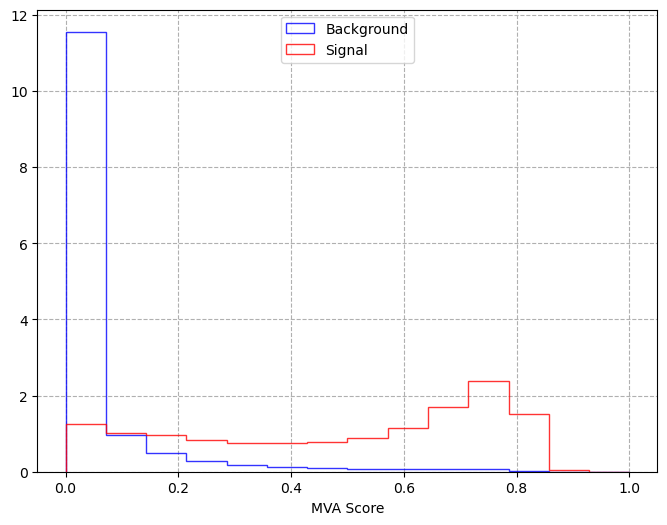

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

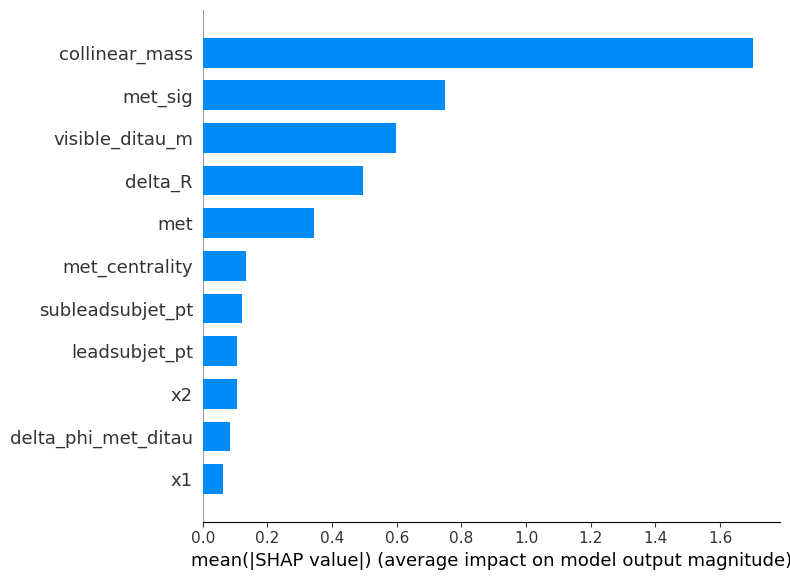

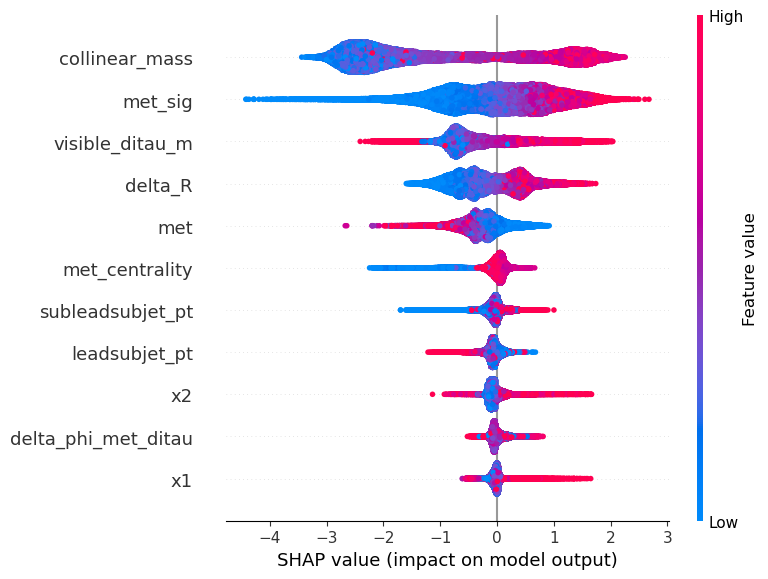

Feature Importance Ranking:
                feature  importance
3        collinear_mass    1.688552
6               met_sig    0.736838
2       visible_ditau_m    0.602225
4               delta_R    0.509444
5                   met    0.332390
9        met_centrality    0.136033
1      subleadsubjet_pt    0.125734
8                    x2    0.114012
0         leadsubjet_pt    0.106921
10  delta_phi_met_ditau    0.074822
7                    x1    0.061442


In [29]:
# Aggregate SHAP values across all folds
mean_shap_values = np.mean([np.abs(shap_values).mean(0) for shap_values in all_shap_values], axis=0)
feature_names = all_feature_names[0]  # Assuming feature names are consistent across folds

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap_values})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
shap.summary_plot(all_shap_values[2], X_test, plot_type="bar", feature_names=feature_names)
shap.summary_plot(all_shap_values[2], X_test, feature_names=feature_names)

# Print feature importance
print("Feature Importance Ranking:")
print(feature_importance)